# Processing

scmdata has some support for processing `ScmRun` instances to calculate statistics of interest. Here we provide examples of how to use them.

## Load some data

For this demonstration, we are going to use MAGICC output from [RCMIP Phase 2] as available at [https://zenodo.org/record/4624566/files/data-processed-submission-database-hadcrut5-target-MAGICCv7.5.1.tar.gz?download=1](). Here we have just extracted the air temperature output for the SSPs from 1995 to 2100.

In [1]:
# NBVAL_IGNORE_OUTPUT
import pandas as pd
import scmdata.processing
from scmdata import ScmRun, run_append

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NBVAL_IGNORE_OUTPUT
magicc_output = ScmRun("magicc-rcmip-phase-2-gsat-output.csv")
magicc_output

<scmdata.ScmRun (timeseries: 4800, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model  ensemble_member        model region scenario unit  \
	0     MAGICCv7.5.1                0  unspecified  World   ssp585    K   
	1     MAGICCv7.5.1                1  unspecified  World   ssp585    K   
	2     MAGICCv7.5.1                2  unspecified  World   ssp585    K   
	3     MAGICCv7.5.1                3  unspecified  World   ssp585    K   
	4     MAGICCv7.5.1                4  unspecified  World   ssp585    K   
	...            ...              ...          ...    ...      ...  ...   
	4795  MAGICCv7.5.1              595  unspecified  World   ssp119    K   
	4796  MAGICCv7.5.1              596  unspecified  World   ssp119    K   
	4797  MAGICCv7.5.1              597  unspecified  World   ssp119    K   
	4798  MAGICCv7.5.1              598  unspecified  World   ssp119    K   
	4799  MAGICCv7.5.1              599  unspecified  World   ssp119  

## Crossing times

The first thing we do is show how to calculate the crossing times of a given threshold.

In [3]:
# NBVAL_IGNORE_OUTPUT
crossing_time_15 = magicc_output.process_over(
    [], scmdata.processing.calculate_crossing_times, threshold=1.5,
)
crossing_time_15

climate_model  ensemble_member  model        region  scenario     unit  variable                      
MAGICCv7.5.1   0                unspecified  World   ssp119       K     Surface Air Temperature Change       NaN
                                                     ssp126       K     Surface Air Temperature Change    2033.0
                                                     ssp245       K     Surface Air Temperature Change    2028.0
                                                     ssp370       K     Surface Air Temperature Change    2026.0
                                                     ssp434       K     Surface Air Temperature Change    2026.0
                                                                                                           ...  
               599              unspecified  World   ssp370       K     Surface Air Temperature Change    2025.0
                                                     ssp434       K     Surface Air Temperature Change    

The output is a `pd.Series`, which is useful for many other pieces of work.

For example, we could make a plot with e.g. seaborn.

<AxesSubplot:xlabel='1.5C crossing time', ylabel='Count'>

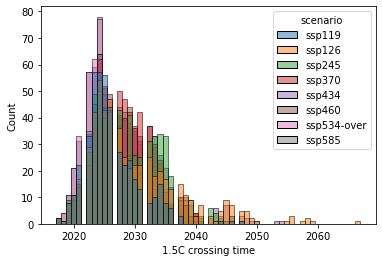

In [4]:
label = "1.5C crossing time"
pdf = crossing_time_15.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

<AxesSubplot:xlabel='2.0C crossing time', ylabel='Count'>

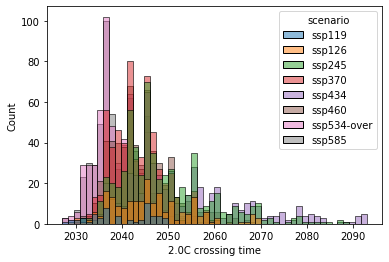

In [5]:
label = "2.0C crossing time"
crossing_time_20 = magicc_output.process_over(
    [], scmdata.processing.calculate_crossing_times, threshold=2.0,
)

pdf = crossing_time_20.reset_index().rename({0: label}, axis="columns")
sns.histplot(data=pdf, x=label, hue="scenario")

## Exceedance probabilities

Next we show how to calculate exceedance probabilities.

In [6]:
exceedance_probability_2C = magicc_output.process_over(
    "ensemble_member",
    scmdata.processing.calculate_exceedance_probabilities,
    threshold=2.0,
)
exceedance_probability_2C

climate_model  model        region  scenario     unit  variable                      
MAGICCv7.5.1   unspecified  World   ssp119       K     Surface Air Temperature Change    0.091667
                                    ssp126       K     Surface Air Temperature Change    0.350000
                                    ssp245       K     Surface Air Temperature Change    0.995000
                                    ssp370       K     Surface Air Temperature Change    1.000000
                                    ssp434       K     Surface Air Temperature Change    0.868333
                                    ssp460       K     Surface Air Temperature Change    1.000000
                                    ssp534-over  K     Surface Air Temperature Change    0.983333
                                    ssp585       K     Surface Air Temperature Change    1.000000
dtype: float64

We can make a plot to compare exceedance probabilities over multiple scenarios.

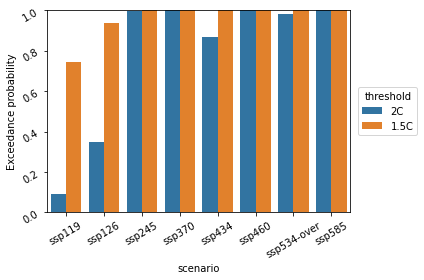

In [7]:
exceedance_probability_15C = magicc_output.process_over(
    "ensemble_member",
    scmdata.processing.calculate_exceedance_probabilities,
    threshold=1.5,
)


def get_pdf(ins, threshold):
    out = ins.reset_index().rename(
        {0: "Exceedance probability"}, axis="columns"
    )
    out["threshold"] = threshold

    return out


pdf = pd.concat(
    [
        get_pdf(exceedance_probability_2C, "2C"),
        get_pdf(exceedance_probability_15C, "1.5C"),
    ]
)
ax = sns.barplot(
    data=pdf, x="scenario", y="Exceedance probability", hue="threshold"
)
ax.tick_params(labelrotation=30)
ax.set_ylim([0, 1])
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), title="threshold")
plt.tight_layout()

### Exceedance probabilities over time

It is also possible to calculate exceedance probabilities over time.

<AxesSubplot:xlabel='time', ylabel='K'>

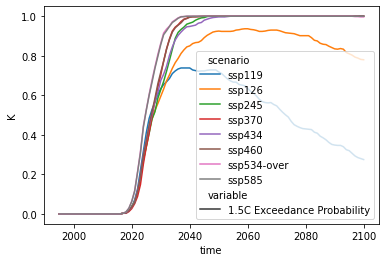

In [8]:
res = magicc_output.process_over(
    "ensemble_member",
    scmdata.processing.calculate_exceedance_probabilities_over_time,
    threshold=1.5,
).reset_index()
res["variable"] = "1.5C Exceedance Probability"
res = scmdata.ScmRun(res)
res.lineplot(style="variable")

Note that taking the maximum exceedance probability over all time will be less than or equal to the exceedance probability calculated with `calculate_exceedance_probabilities` because the order of operations matters: calculating whether each ensemble member exceeds the threshold or not then seeing how many ensemble members out of the total exceed the threshold is not the same as seeing how many ensemble members exceed the threshold at each timestep and then taking the maximum over all timesteps. In general, taking the maximum value from `calculate_exceedance_probabilities_over_time` will be less than or equal to the results of `calculate_exceedance_probabilities`, as demonstrated below.

In [9]:
pd.DataFrame(
    {
        "calculate_exceedance_probabilities": exceedance_probability_15C.reset_index(
            "variable", drop=True
        ),
        "max of calculate_exceedance_probabilities_over_time": res.timeseries()
        .max(axis=1)
        .reset_index("variable", drop=True),
    }
).round(3)

calculate_exceedance_probabilities  \
climate_model model       region scenario    unit                                       
MAGICCv7.5.1  unspecified World  ssp119      K                                  0.743   
                                 ssp126      K                                  0.940   
                                 ssp245      K                                  1.000   
                                 ssp370      K                                  1.000   
                                 ssp434      K                                  1.000   
                                 ssp460      K                                  1.000   
                                 ssp534-over K                                  1.000   
                                 ssp585      K                                  1.000   

                                                   max of calculate_exceedance_probabilities_over_time  
climate_model model       region scenario    unit                                                       
MAGICCv7.5.1  unspecified World  ssp119      K                                                 0.738    
                                 ssp126      K                                                 0.937    
                                 ssp245      K                                                 1.000    
                                 ssp370      K                                                 1.000    
                                 ssp434      K                                                 1.000    
                                 ssp460      K                                                 1.000    
                                 ssp534-over K                                                 1.000    
                                 ssp585      K                                                 1.000